# Introduction

This notebook uses already preprocessed data to do feature engineering with. The goal is to implement a linear discriminant analysis model to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook. 

## Imports

In [2]:
import h5py 
import mat73
import numpy as np
import mne
from matplotlib import pyplot as plt

## Load the Data

In [4]:
setup_path = '/run/user/1006/gvfs/smb-share:server=10.162.37.21,share=main/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Setup.mat'
raw_path = '/run/user/1006/gvfs/smb-share:server=10.162.37.21,share=main/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Raw.mat'
data_path = '/run/user/1006/gvfs/smb-share:server=10.162.37.21,share=main/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject06_snapshot_normalized.npy'

raw_file = h5py.File(raw_path)
setup_data = mat73.loadmat(setup_path)

In [6]:
data = np.load(data_path, allow_pickle=True)

ValueError: cannot reshape array of size 155011056 into shape (185,133,63,100)

In [7]:
data.shape

NameError: name 'data' is not defined

In [5]:
num_channels = data.shape[1]
num_timesteps = data.shape[3]
data.shape

(185, 133, 63, 100)

## Data Visualization

In [ ]:
from matplotlib import cm

# Plot the PSD graph of Subject 06, Trial #1, Channel #1
fig = plt.figure()
ax = plt.axes(projection="3d")

time = np.arange(0,100,1)
wavlet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

x1, y1 = np.meshgrid(time,wavlet_freqs)

surf = ax.plot_surface(x1, y1, data[0,0], cmap='inferno')
ax.set_title('Power')
ax.set_ylabel('Time')
ax.set_xlabel('Frequency')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [6]:
bets = setup_data['filters']['bets']
y = np.asarray([(0 if bet == 5 else 1) for bet in bets if not np.isnan(bet)])

In [7]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_accuracies = np.zeros((num_channels, num_timesteps, 5))  # Number of cross-validation folds (e.g., 5)

for channel in range(num_channels):
    for time in range(num_timesteps):
        X = data[:, channel, :, time]
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        cv_results = cross_validate(lda, X, y, cv=5)
        model_accuracies[channel, time] = cv_results['test_score']

In [36]:
# Calculating t-statistic for each channel and timepoint

from scipy.stats import ttest_1samp
t_stats = np.zeros((num_channels,num_timesteps))
for channel in range(num_channels):
        for time in range(num_timesteps):
            t_stats[channel,time] = ttest_1samp(model_accuracies[channel,time],0.5).statistic


In [ ]:
print(t_stats.shape)
print(t_stats[0,:]) # t-values for all time steps for channel 1

In [75]:
mean_accuracies = np.mean(model_accuracies, axis=(2)) # Create an array storing the average accuracies for each channel at each timepoint
mean_accuracies_max = np.zeros((num_channels,2))

for channel in range(num_channels):
    mean_accuracies_max[channel, 0] = mean_accuracies[channel,:].max()
    mean_accuracies_max[channel, 1] = list(mean_accuracies[channel]).index(mean_accuracies[channel,:].max()) # the time point at which the maximum accuracy occurs

top_ten_accuracies_index = np.argsort(mean_accuracies_max[:,0])[-10:] # store the channel indices of the top 10 accuracies 

In [76]:
print(np.argsort(mean_accuracies_max[:,0]))
print(top_ten_accuracies_index)
print(mean_accuracies_max[top_ten_accuracies_index])

[104   6 132  95 107  99  43 125  32  98 119   2  75  36  78 124  22  80
  70  72  84  64 103  60 118 126  85  58 120  40 127  50  82  13  88 122
  20  59  16 129  37 106  65  71  77  51  89 114 128 105 116   8  24 121
  17  38  42 123  46  47  93  52  21  81  19  31  18  69  34  67   1  27
 108  91 113  57 117  96 100  74  49  29  53   5  45 115  33   3  86  41
  14  76 102  62  12  83  30  94 130  66  61  87  25  48  97  15  90  73
  26  35  23  28  54 110   4  56 111 109  63  79   7  11  55 101  68   9
  10   0 112 131  39  92  44]
[101  68   9  10   0 112 131  39  92  44]
[[ 0.65405405 65.        ]
 [ 0.65945946 46.        ]
 [ 0.65945946 60.        ]
 [ 0.65945946 63.        ]
 [ 0.65945946 23.        ]
 [ 0.65945946 67.        ]
 [ 0.65945946 47.        ]
 [ 0.65945946 95.        ]
 [ 0.66486486 26.        ]
 [ 0.67027027 56.        ]]


# Visualization of the Accuracy of the Models

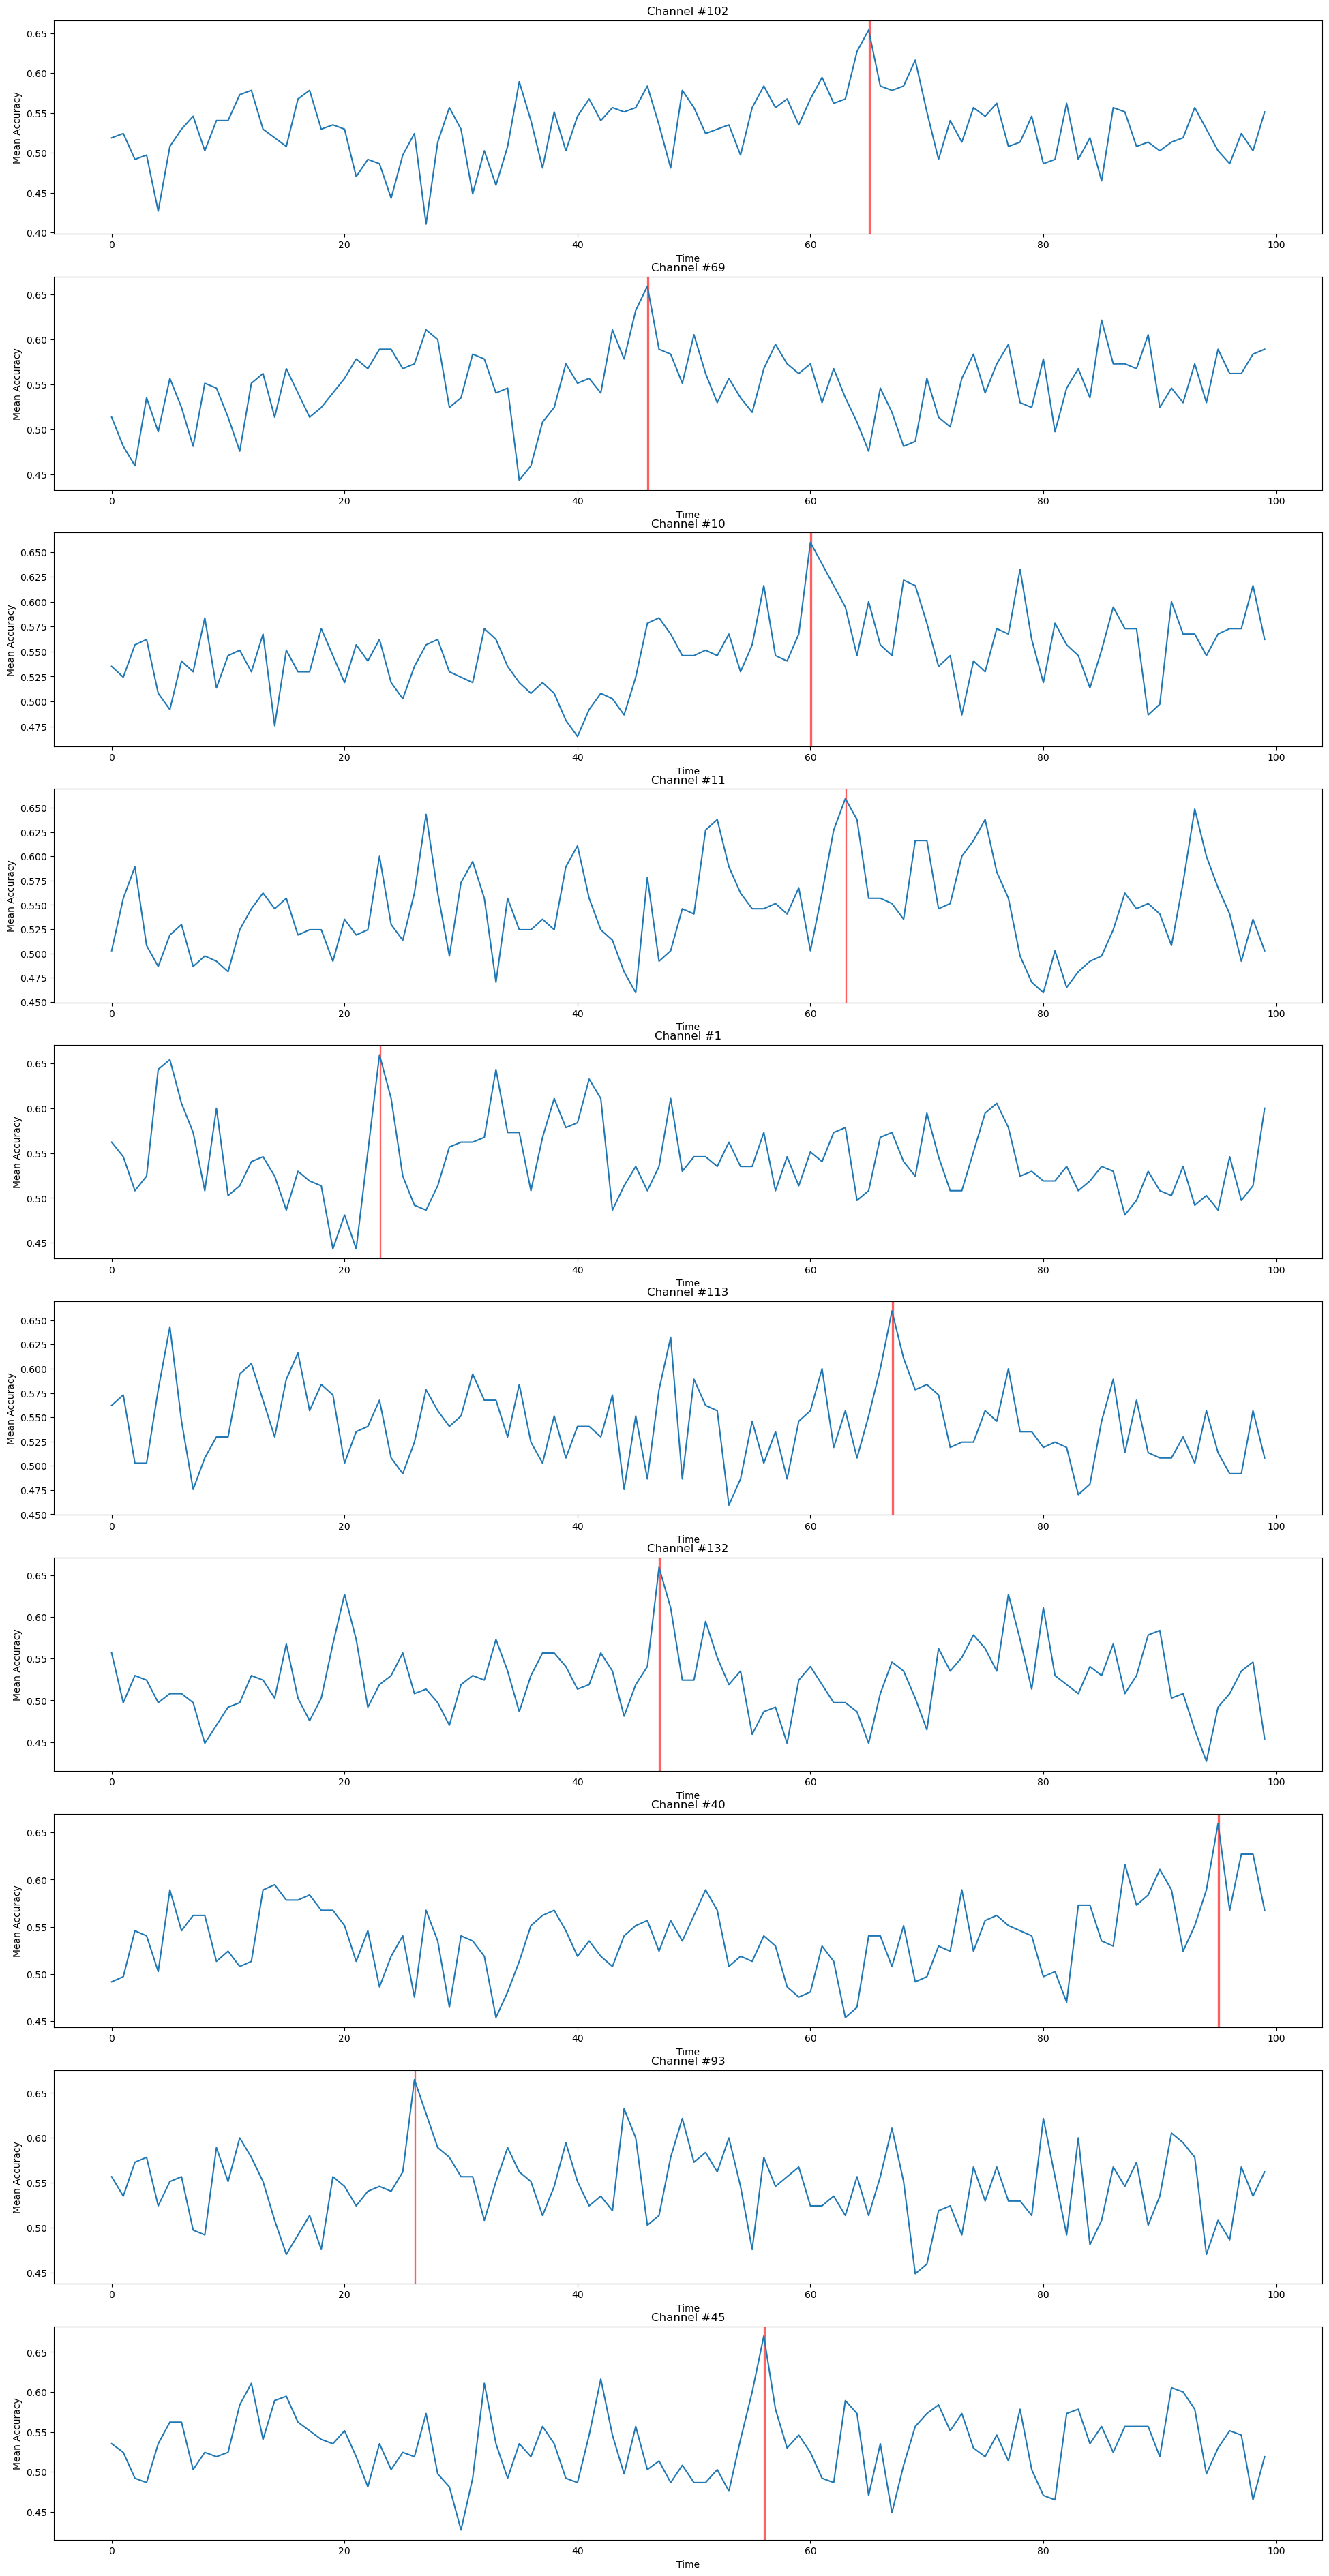

In [72]:
# Plot the mean accuracy vs time graph of the top 10 channels with the highest accuracy

fig, axs = plt.subplots(10, 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(top_ten_accuracies_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')
    ax.axvspan(mean_accuracies_max[channel,1],mean_accuracies_max[channel,1]+.1,color = 'red', alpha=0.5)

plt.savefig('top_ten_accuracies.png')
plt.show()

In [71]:
plt.savefig('top_ten_accuracies.png')

<Figure size 640x480 with 0 Axes>

<AxesSubplot: >

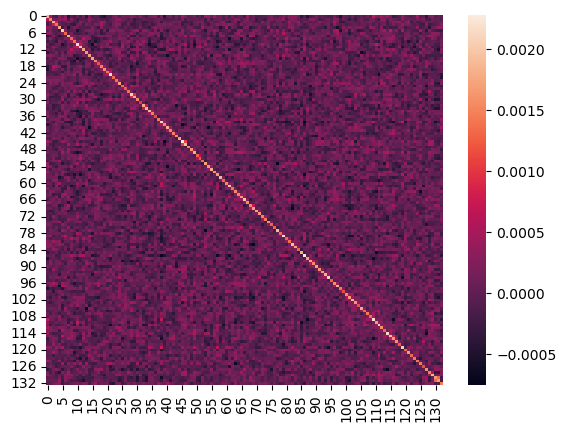

In [65]:
import seaborn as sns

cov = np.cov(mean_accuracies)
sns.heatmap(cov)

In [66]:
cov_max = np.zeros((num_channels,2))
cov_diag = np.zeros((num_channels))

for channel in range(num_channels):
    # cov_max[channel] = cov[channel].max() # Used to sanity check that cov_diag == cov_max
    cov_temp = cov[channel, np.arange(num_channels) != channel] # Get the entire row 
    cov_max[channel,0] = cov_temp.max()
    cov_max[channel,1] = int(list(cov_temp).index(cov_temp.max())) # Get the corresponding channel that has the highest covariance
    cov_diag[channel] = cov[channel,channel]

In [67]:
# print(cov_diag)
# print(cov_max)
# print(cov[0,0])

# print(cov_diag==cov_max) # Used to sanity check that cov_diag == cov_max
# print(cov_max/cov_diag)

# print(cov_max[0])

cov_ratio = (cov_max[:,0]/cov_diag) # Get the ratios of the maximum value of the covariance (non-diagonal) to the value of the diagonal
cov_index = []

for i, covariance in enumerate(cov_ratio):
     if covariance > .5:
            cov_index.append(i)

print(cov_index)


[3, 29, 46, 51, 130, 131]


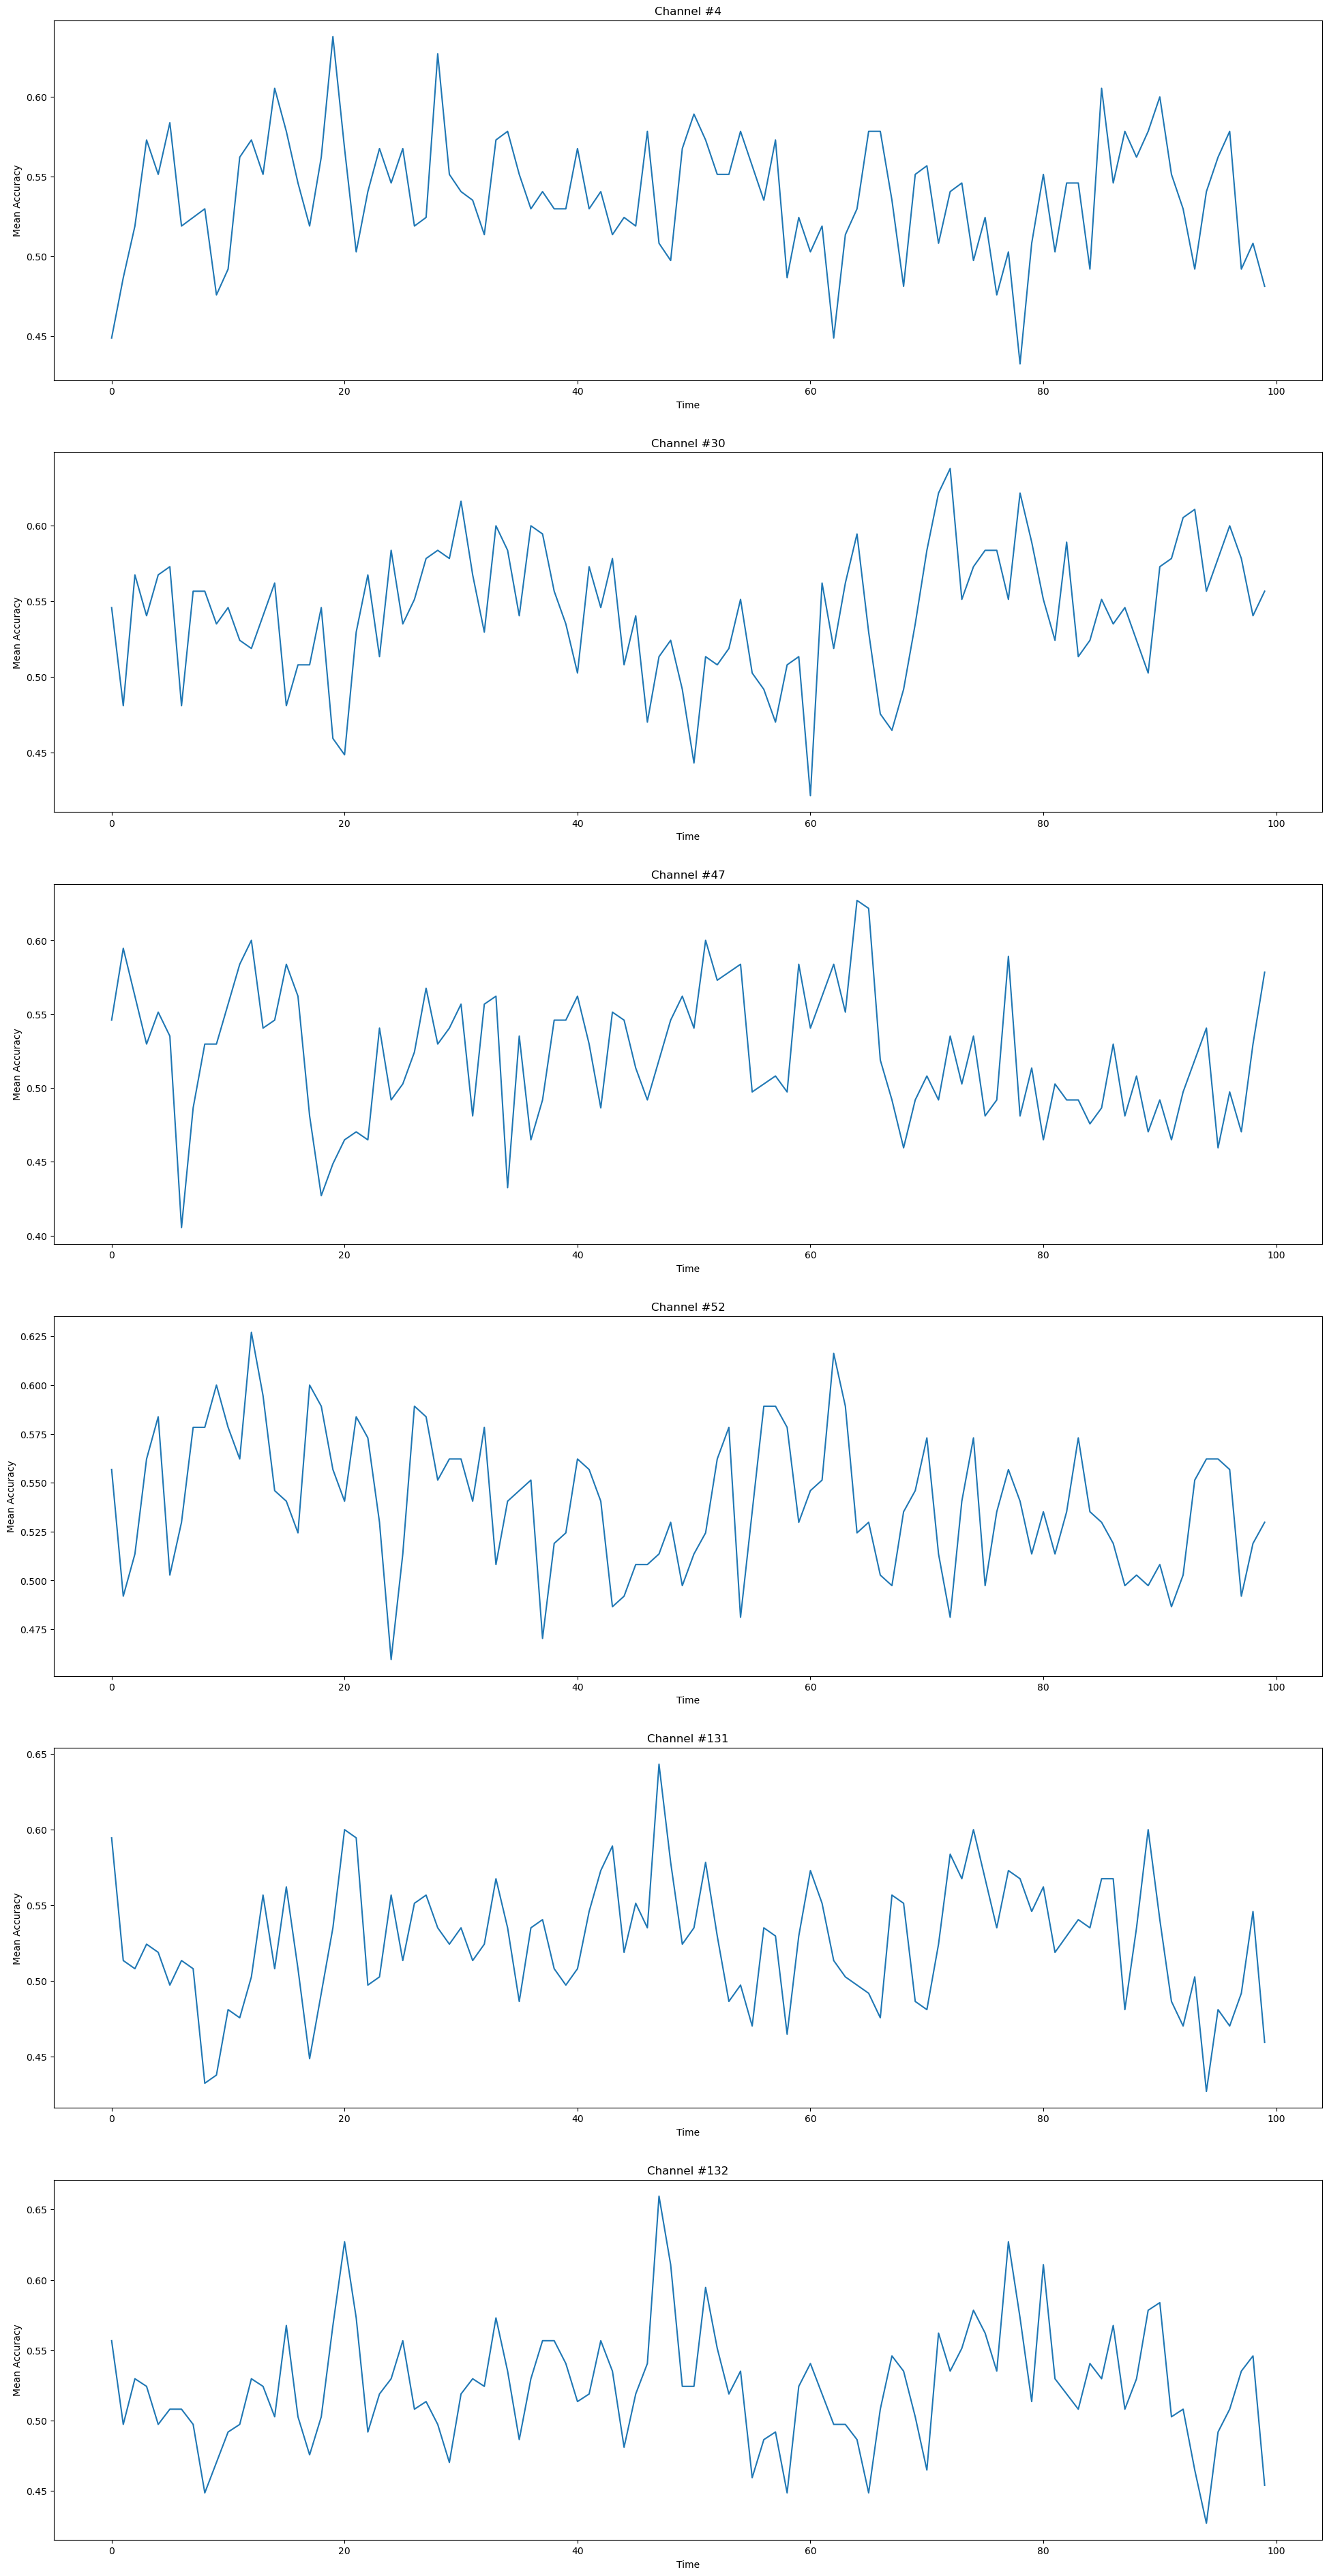

In [69]:
# Prints the mean accuracy vs time graphs of the channels with the highest covariance

fig, axs = plt.subplots(len(cov_index), 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(cov_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')

plt.show()

# Extraneous Code

In [55]:
max_accuracy = np.

for channels in range(num_channels):
    for time in range(num_timesteps):


0.3675675675675676

In [41]:
# Sanity check that t_values make sense

print(mean_accuracies[0,15])
print(t_stats[0,:])

0.4864864864864865
[ 2.25533555  2.125       0.40824829  3.67423461  9.08942501  9.77541935
  4.47360681  7.21605353  0.20507578  3.81625861  0.04632411  0.29880715
  1.67705098  4.54344111  0.91855865 -0.55901699  1.02132436  0.43082022
  0.40824829 -2.26448824 -0.44812908 -2.40886521  1.84544314  7.26239797
  3.09049128  0.61237244 -0.51449576 -0.52704628  0.40824829  1.68134561
  2.875       2.37226887  1.91741247  3.80517824  2.52878169  1.47737427
  0.19611614  1.58113883  2.85660536  2.25083652 12.655697    5.00104156
  3.00626586 -0.5         0.32969024  0.84983659  0.32732684  1.5112193
  3.98227204  0.8291562   1.75341612  1.97620986  1.04756985  1.85339282
  0.63133581  1.27475488  2.10834579  0.21004201  1.75341612  0.40824829
  1.84544314  1.43019388  2.52878169  2.816729   -0.08908708  0.375
  1.37620471  2.04686472  1.36930639  0.69853547  3.91311896  1.97620986
  0.24174689  0.40824829  2.33873833  3.91311896  2.85961874  2.18595725
  0.97049496  2.75        0.6047079   

In [ ]:
#Trying to implement k-fold cross validation approach with RepeatedKFold 

from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits = 5, n_repeats=10, random_state=42)

for channel in range(133):
    for time in range(100):
        X = data[:, channel, :, time]
        fold_index = 0
        for train_index, test_index in rkf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
            lda.fit(X_train, y_train)

            if fold_index < 5:
                model_accuracies[channel, time, fold_index] = lda.score(X_test, y_test)

            fold_index += 1

In [ ]:
model_accuracies_na = model_accuracies

In [ ]:
model_accuracies_lsqr = model_accuracies

In [ ]:
model_accuracies_eigen = model_accuracies

In [ ]:
for i in range(133):
    print('Channel %i The accuracy for the model without regularization: %f' %(model_accuracies_na[i].mean()))
    print('Channel %i The accuracy for the model with regularization (lsqr): %f' %(model_accuracies_lsqr[i].mean()))
    print('Channel %i The accuracy for the model with regularization (eigen): %f' %(model_accuracies_eigen[i].mean()))